In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Overview of Notebook: 

Use pre-processed flight/airport/weather data to fit using machine learning to create a predictor of flight delays.
Loaded and finalized any preprocessing steps (target variable delay_minutes is pre-scaled), updating data types as needed.
Apply label encoding to each categorical column
Perform One-Hot Encoding on binary categorical features
Feature Selecture: Removed all features that were too highly correlated per correlation analysis in preprocessing. 
Then run the following regressors to try to fit the data.

Delay is Continuous (Regression Problem):

Linear Regression: A simple starting point.

Random Forest Regressor: Non-linear model that performs well in many cases.

Gradient Boosting: Powerful algorithms like XGBoost, LightGBM, or CatBoost can often outperform random forests.
77

Compared all RMSE, MAE, and R^2 values.  
Ultimately Random Forest Regression performed best, as outlined below. 
Hypertuned parameters on RFR, tested, trained, and used it to test new data with the current final outcome below.

MAE: 0.0029990546079890273
MSE: 0.00111529610502451
R²: 0.9996975678399977



In [2]:
# Load preprocessed data

df = pd.read_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessed_data_week.csv', low_memory=False)


In [3]:
df.columns

Index(['day_of_week', 'timestamp', 'op_unique_carrier', 'op_carrier_fl_num',
       'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'taxi_out',
       'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_state', 'dest_state', 'origin_latitude',
       'origin_longitude', 'dest_latitude', 'dest_longitude',
       'type_of_airport', 'elevation_ft', 'length_ft', 'width_ft', 'surface',
       'lighted', 'latitude_orig', 'longitude_orig', 'elevation_orig',
       'tmax_orig', 'tmin_orig', 'weather_indicator', 'total_delay_time',
       'is_weekend', 'arrival_delay', 'departure_delay', 'airline_name',
       'nfl_game', 'delay_columns', 'latitude_dest', 'longitude_dest',
       'elevation_dest', 'tmax_dest', 'tmin_dest', 'flight_delay_category',
       'delay_minutes'],
      dtype='object')

In [4]:
df['flights'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: flights, dtype: float64

In [5]:
df.columns

Index(['day_of_week', 'timestamp', 'op_unique_carrier', 'op_carrier_fl_num',
       'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'taxi_out',
       'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_state', 'dest_state', 'origin_latitude',
       'origin_longitude', 'dest_latitude', 'dest_longitude',
       'type_of_airport', 'elevation_ft', 'length_ft', 'width_ft', 'surface',
       'lighted', 'latitude_orig', 'longitude_orig', 'elevation_orig',
       'tmax_orig', 'tmin_orig', 'weather_indicator', 'total_delay_time',
       'is_weekend', 'arrival_delay', 'departure_delay', 'airline_name',
       'nfl_game', 'delay_columns', 'latitude_dest', 'longitude_dest',
       'elevation_dest', 'tmax_dest', 'tmin_dest', 'flight_delay_category',
       'delay_minutes'],
      dtype='object')

In [6]:
# Drop columns
# Remove arrival_delay: Since it has a perfect correlation with delay_minutes, 
# it’s likely capturing the same information and should be removed to avoid leakage.


# Drop columns correctly
df = df.drop(columns=['taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_elapsed_time', 
                      'origin_latitude', 'origin_longitude', 'dest_latitude', 'dest_longitude', 
                      'type_of_airport', 'latitude_orig', 'longitude_orig', 'elevation_ft', 
                      'latitude_dest', 'longitude_dest', 'total_delay_time', 'flight_delay_category', 
                      'arrival_delay', 'flights', 'crs_arr_time', 'timestamp'], axis=1)

# Check the columns after dropping
print(df.columns)


Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata',
       'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time',
       'actual_elapsed_time', 'air_time', 'distance', 'origin_state',
       'dest_state', 'length_ft', 'width_ft', 'surface', 'lighted',
       'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator',
       'is_weekend', 'departure_delay', 'airline_name', 'nfl_game',
       'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest',
       'delay_minutes'],
      dtype='object')


In [7]:
df.head()

,day_of_week,op_unique_carrier,op_carrier_fl_num,origin_iata,dest_iata,crs_dep_time,dep_time,arr_time,actual_elapsed_time,air_time,...,weather_indicator,is_weekend,departure_delay,airline_name,nfl_game,delay_columns,elevation_dest,tmax_dest,tmin_dest,delay_minutes
0,1,ua,2155,lax,ewr,450,443.0,1200.0,124.0,98.0,...,0.0,0,-7.0,united airlines,no,0.0,125.0,84.0,66.0,2.623514
1,1,ua,2155,lax,ewr,450,443.0,1200.0,124.0,98.0,...,0.0,0,-7.0,united airlines,no,0.0,125.0,84.0,66.0,2.623514
2,1,ua,438,cle,iad,1188,1286.0,1356.0,70.0,46.0,...,0.0,0,98.0,united airlines,no,94.0,791.0,84.0,66.0,0.863516
3,1,ua,438,cle,iad,1188,1286.0,1356.0,70.0,46.0,...,0.0,0,98.0,united airlines,no,94.0,791.0,84.0,66.0,0.863516
4,1,ua,438,cle,iad,1188,1286.0,1356.0,70.0,46.0,...,0.0,0,98.0,united airlines,no,94.0,791.0,84.0,66.0,0.863516


In [8]:
# To select and display only columns with object (string) data type
object_columns = df.select_dtypes(include='object').columns
print(object_columns)


Index(['op_unique_carrier', 'origin_iata', 'dest_iata', 'origin_state',
       'dest_state', 'surface', 'airline_name', 'nfl_game'],
      dtype='object')


In [9]:
# Convert all object columns to category type
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').astype('category')


In [10]:
# Verify the data types after conversion
print(df.dtypes)


day_of_week               int64
op_unique_carrier      category
op_carrier_fl_num         int64
origin_iata            category
dest_iata              category
crs_dep_time              int64
dep_time                float64
arr_time                float64
actual_elapsed_time     float64
air_time                float64
distance                float64
origin_state           category
dest_state             category
length_ft               float64
width_ft                float64
surface                category
lighted                   int64
elevation_orig          float64
tmax_orig               float64
tmin_orig               float64
weather_indicator       float64
is_weekend                int64
departure_delay         float64
airline_name           category
nfl_game               category
delay_columns           float64
elevation_dest          float64
tmax_dest               float64
tmin_dest               float64
delay_minutes           float64
dtype: object


day_of_week: The day of the week (likely encoded as integers, e.g., 0 = Sunday, 1 = Monday, etc.).
op_unique_carrier: The carrier code for the airline operating the flight.
op_carrier_fl_num: The unique flight number assigned by the airline.
origin_iata: IATA code for the origin airport.
dest_iata: IATA code for the destination airport.
crs_dep_time: The scheduled departure time (in minutes, probably in HHMM format).
dep_time: The actual departure time.
crs_arr_time: The scheduled arrival time (again, probably in HHMM format).
arr_time: The actual arrival time.
actual_elapsed_time: The actual elapsed time of the flight (in minutes).
air_time: The time spent in the air, excluding any ground time.
distance: The distance traveled during the flight (likely in miles or kilometers).
origin_state: The state where the origin airport is located.
dest_state: The state where the destination airport is located.
length_ft: Length of the aircraft (in feet).
width_ft: Width of the aircraft (in feet).
surface: The surface type of the runway (e.g., asphalt, concrete).
lighted: Indicates if the airport runway is lighted (1 = yes, 0 = no).
elevation_orig: The elevation (in feet or meters) of the origin airport.
tmax_orig: The maximum temperature (likely in degrees Fahrenheit or Celsius) at the origin airport on the day of the flight.
tmin_orig: The minimum temperature at the origin airport on the day of the flight.
weather_indicator: A numerical value representing weather conditions (could be coded or indexed).
is_weekend: Indicates whether the flight was on a weekend (1 = yes, 0 = no).
departure_delay: The delay (in minutes) in the flight's departure.
airline_name: The full name of the airline.
nfl_game: Indicates if there was an NFL game related to the flight (likely categorical: yes/no).
delay_columns: A numerical representation of flight delays (could be related to various factors).
elevation_dest: The elevation (in feet or meters) of the destination airport.
tmax_dest: The maximum temperature at the destination airport.
tmin_dest: The minimum temperature at the destination airport.
delay_minutes: Total delay time in minutes, possibly aggregating both departure and arrival delays.

In [12]:
df['surface'].head()

0    con
1    con
2    con
3    con
4    con
Name: surface, dtype: category
Categories (15, object): ['asp', 'asph', 'asph-f', 'asph-g', ..., 'gvl', 'pem', 'per', 'water']

In [13]:
df.dtypes

day_of_week               int64
op_unique_carrier      category
op_carrier_fl_num         int64
origin_iata            category
dest_iata              category
crs_dep_time              int64
dep_time                float64
arr_time                float64
actual_elapsed_time     float64
air_time                float64
distance                float64
origin_state           category
dest_state             category
length_ft               float64
width_ft                float64
surface                category
lighted                   int64
elevation_orig          float64
tmax_orig               float64
tmin_orig               float64
weather_indicator       float64
is_weekend                int64
departure_delay         float64
airline_name           category
nfl_game               category
delay_columns           float64
elevation_dest          float64
tmax_dest               float64
tmin_dest               float64
delay_minutes           float64
dtype: object

In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
df['day_of_week'] = label_encoder.fit_transform(df['day_of_week'])
df['op_carrier_fl_num'] = label_encoder.fit_transform(df['op_carrier_fl_num'])
df['op_unique_carrier'] = label_encoder.fit_transform(df['op_unique_carrier'])
df['origin_iata'] = label_encoder.fit_transform(df['origin_iata'])
df['dest_iata'] = label_encoder.fit_transform(df['dest_iata'])
df['origin_state'] = label_encoder.fit_transform(df['origin_state'])
df['dest_state'] = label_encoder.fit_transform(df['dest_state'])
df['airline_name'] = label_encoder.fit_transform(df['airline_name'])
df['nfl_game'] = label_encoder.fit_transform(df['nfl_game'])
df['surface'] = label_encoder.fit_transform(df['surface'])

In [15]:
# Perform One-Hot Encoding on binary categorical features
df = pd.get_dummies(df, columns=['lighted', 'is_weekend'])


In [16]:
# Convert categorical variables to dummy variables
# df_encoded = pd.get_dummies(df, drop_first=True)


In [17]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [18]:
# Convert categorical columns to numeric to review correlation matrix

In [19]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in df.select_dtypes(include=['category']).columns:
    df[column] = label_encoder.fit_transform(df[column])

# Now calculate the correlation matrix
correlation_matrix = df.corr()

# Print the sorted correlation values with respect to 'delay_minutes'
print(correlation_matrix['delay_minutes'].sort_values(ascending=False))


delay_minutes          1.000000
delay_columns          0.324469
arr_time               0.098257
dep_time               0.053221
departure_delay        0.045177
length_ft              0.022759
is_weekend_0           0.019506
crs_dep_time           0.018744
origin_iata            0.017833
distance               0.014690
lighted_1              0.014499
dest_state             0.011264
width_ft               0.010603
op_carrier_fl_num      0.002309
elevation_dest        -0.003640
airline_name          -0.006250
day_of_week           -0.007303
surface               -0.007428
weather_indicator     -0.008232
origin_state          -0.013678
op_unique_carrier     -0.014235
lighted_0             -0.014499
elevation_orig        -0.015865
dest_iata             -0.017985
is_weekend_1          -0.019506
tmin_orig             -0.021999
tmin_dest             -0.021999
air_time              -0.025870
actual_elapsed_time   -0.032596
tmax_orig             -0.032756
tmax_dest             -0.032756
nfl_game

In [20]:
from sklearn.model_selection import train_test_split
X = df.drop('delay_minutes', axis=1)  # Features
y = df['delay_minutes']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
print(X_train.columns)

Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1'], dtype='object')


In [22]:
print(X_test.columns)

Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1'], dtype='object')


In [23]:
X_test.dtypes

day_of_week              int64
op_unique_carrier        int32
op_carrier_fl_num        int64
origin_iata              int32
dest_iata                int32
crs_dep_time             int64
dep_time               float64
arr_time               float64
actual_elapsed_time    float64
air_time               float64
distance               float64
origin_state             int32
dest_state               int32
length_ft              float64
width_ft               float64
surface                  int32
elevation_orig         float64
tmax_orig              float64
tmin_orig              float64
weather_indicator      float64
departure_delay        float64
airline_name             int32
nfl_game                 int32
delay_columns          float64
elevation_dest         float64
tmax_dest              float64
tmin_dest              float64
lighted_0                 bool
lighted_1                 bool
is_weekend_0              bool
is_weekend_1              bool
dtype: object

In [24]:
# # Columns to convert
# columns_to_convert = ['day_of_week', 'op_carrier_fl_num', 'is_weekend']

# # Convert columns in X_train
# X_train[columns_to_convert] = X_train[columns_to_convert].astype('object')
# # 
# # Convert columns in X_test
# X_test[columns_to_convert] = X_test[columns_to_convert].astype('object')


In [25]:
# Check the datatypes of your features
print(X.dtypes)


day_of_week              int64
op_unique_carrier        int32
op_carrier_fl_num        int64
origin_iata              int32
dest_iata                int32
crs_dep_time             int64
dep_time               float64
arr_time               float64
actual_elapsed_time    float64
air_time               float64
distance               float64
origin_state             int32
dest_state               int32
length_ft              float64
width_ft               float64
surface                  int32
elevation_orig         float64
tmax_orig              float64
tmin_orig              float64
weather_indicator      float64
departure_delay        float64
airline_name             int32
nfl_game                 int32
delay_columns          float64
elevation_dest         float64
tmax_dest              float64
tmin_dest              float64
lighted_0                 bool
lighted_1                 bool
is_weekend_0              bool
is_weekend_1              bool
dtype: object


In [26]:
print(X.columns)
print(X_train.columns)

Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1'], dtype='object')
Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1'], dtype='object')


In [27]:
X.select_dtypes(include='object').columns
print(X.dtypes)

day_of_week              int64
op_unique_carrier        int32
op_carrier_fl_num        int64
origin_iata              int32
dest_iata                int32
crs_dep_time             int64
dep_time               float64
arr_time               float64
actual_elapsed_time    float64
air_time               float64
distance               float64
origin_state             int32
dest_state               int32
length_ft              float64
width_ft               float64
surface                  int32
elevation_orig         float64
tmax_orig              float64
tmin_orig              float64
weather_indicator      float64
departure_delay        float64
airline_name             int32
nfl_game                 int32
delay_columns          float64
elevation_dest         float64
tmax_dest              float64
tmin_dest              float64
lighted_0                 bool
lighted_1                 bool
is_weekend_0              bool
is_weekend_1              bool
dtype: object


In [28]:
# # using Binary Encoding for categorical columns
# # useful when you have a large number of categories. compact representation but still want to avoid one-hot encoding’s high dimensionality.
# import category_encoders as ce
# encoder = ce.BinaryEncoder(cols=['carrier_code', 'origin_iata', 'dest_iata', 'origin_state', 'dest_state', 'surface', 'lighted', 'airline_name', 'nfl_game', 'day_of_week', 'op_carrier_fl_num', 'is_weekend'])

# X_train = encoder.fit_transform(X_train)
# X_test = encoder.transform(X_test)


Delay is Continuous (Regression Problem):

Linear Regression: A simple starting point.

Random Forest Regressor: Non-linear model that performs well in many cases.

Gradient Boosting: Powerful algorithms like XGBoost, LightGBM, or CatBoost can often outperform random forests.


If Delay is Categorical (Classification Problem) (e.g., delayed or not delayed):

Logistic Regression: Simple but effective for binary classification.

Random Forest Classifier: Good for high-dimensional datasets.

XGBoost / LightGBM: Perform well on classification tasks with large datasets.

## Regression

In [31]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_linear = lr_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")


Linear Regression MSE: 3.327248960038534


In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Generate predictions using your linear regression model
y_pred = lr_model.predict(X_test)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")


RMSE: 1.8240748230372936
MAE: 0.708766058029163
R-squared (R²): 0.13200046462198867


RMSE (1.82): This indicates that, on average, the predictions differ from the actual values by approximately 1.82 minutes.

MAE (0.71): This shows that the average absolute error is around 0.71 minutes. MAE is generally lower than RMSE because it doesn’t square the errors, so it provides a more straightforward view of the average error magnitude.

R-squared (0.13): An R² of 0.13 suggests that only 13% of the variance in the target variable is explained by the model, which is quite low. This typically indicates that the model is not capturing much of the underlying pattern in the data.

After Revisions: Indicates poor performance, meaning the model's predictions are far from the true values.

Original: An MSE of 1.2033458030242233e-29 for linear regression is extremely low, almost suggesting that your model has an almost perfect fit on the test set, which is unusual in real-world scenarios and may indicate one of the following:

Data Leakage: There might be information in the test data that the model has already seen in the training phase. For instance, if some columns in X_train or X_test have direct or indirect relationships to the target variable (delay), this can lead to artificially high accuracy.

Target Variable Leakage: If the target variable (delay) itself or a proxy of it is inadvertently included in the feature set, this would also lead to a near-perfect prediction.

Numerical Precision or Model Fit: Since linear regression minimizes MSE by design, it could theoretically achieve such a low value if the data points fall almost perfectly on a linear line. Unlikely.

In [34]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rfr_model.predict(X_test)

# Evaluate model
print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 0.005705639221173121


The fact that I have a low MAE (very close to zero) but a high MSE suggests that the model might be performing well on average but struggling with a few outliers. I can confirm this by plotting the residuals (the differences between actual and predicted values) to check for any patterns or extreme outliers.

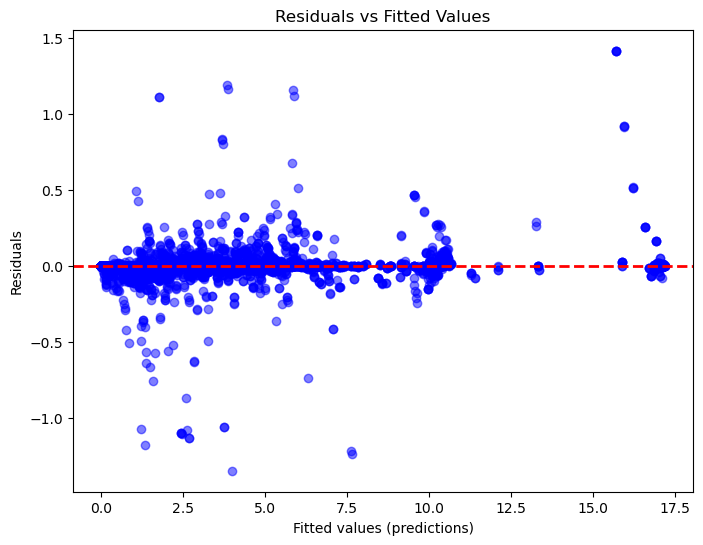

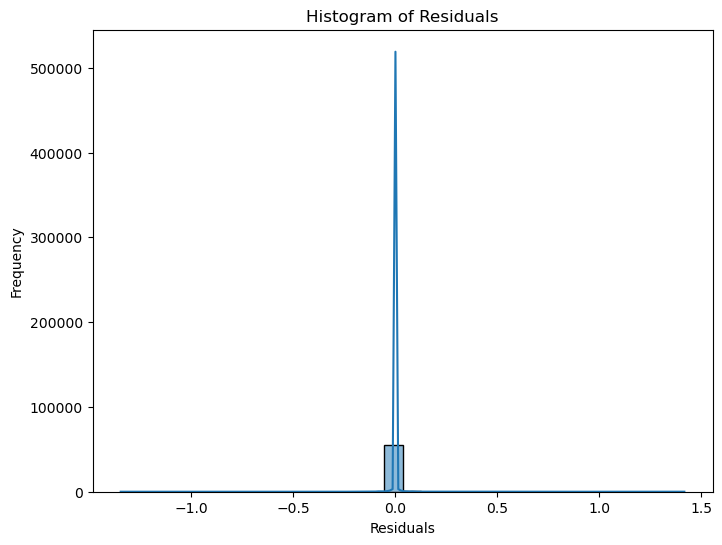

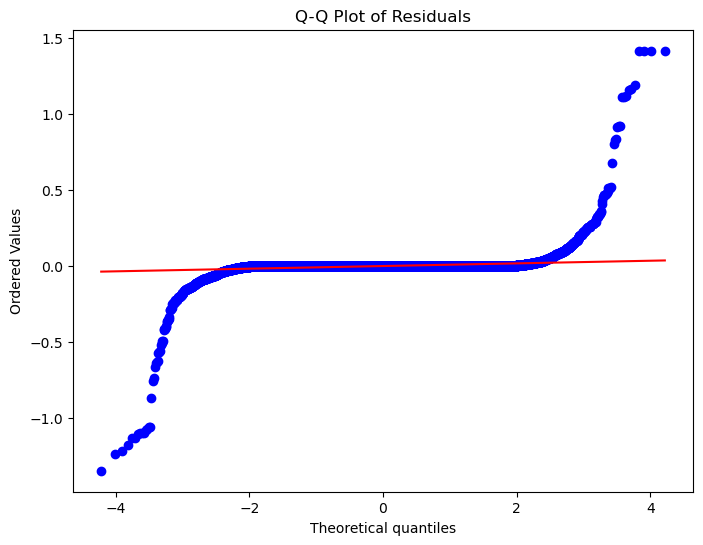

In [36]:
# Plot the residuals

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_true = df['delay_minutes'] 
y_pred = rfr_model.predict(df.drop('delay_minutes', axis=1)) 
# 1. Calculate residuals
residuals = y_true - y_pred

# 2. Residuals vs. Fitted Values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)  # Add a horizontal line at 0
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted values (predictions)')
plt.ylabel('Residuals')
plt.show()

# 3. Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 4. Q-Q Plot
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


In [37]:
# Gradient Boosting Model

from xgboost import XGBRegressor

# Initialize and train the model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}")


XGBoost MSE: 0.00646188324127791


In [100]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate predictions using your XGBoost model
y_pred = xgb_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")


MSE: 0.00646188324127791
RMSE: 0.08038583980576373
R-squared (R²): 0.9983142494840449
MAE: 0.010784823386826802


Final XGBoost MSE of 0.00646 is average error of about 0.08

Initial runthrough indicated that there was likely some data leakage. After review, went back to the original df to remove some of the highly correlated features. After removing arrival_delay, I re-trained the models and checked the MSE and MAE to see if they now show more typical values. Unfortunately, instead of getting closer to one, all the MSE values got even closer to zero.

Need to investigate further.

In [40]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor

# # List of potentially leaking columns
# potential_leakage_columns = ['dep_time', 'arr_time', 'departure_delay', 
#                              'actual_elapsed_time', 'air_time', 'delay_columns']

# # Original features and target split
# X = df.drop(columns=['delay_minutes'])
# y = df['delay_minutes']

# # Perform train-test split once on the original data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# # Columns to convert
# columns_to_convert = ['day_of_week', 'op_carrier_fl_num']

# # Convert columns in X_train
# X_train[columns_to_convert] = X_train[columns_to_convert].astype('object')

# # Convert columns in X_test
# X_test[columns_to_convert] = X_test[columns_to_convert].astype('object')

# # using Binary Encoding for categorical columns
# # useful when you have a large number of categories. compact representation but still want to avoid one-hot encoding’s high dimensionality.
# import category_encoders as ce
# encoder = ce.BinaryEncoder(cols=['op_unique_carrier', 'origin_iata', 'dest_iata', 'origin_state', 'dest_state', 'surface', 'lighted', 'airline_name', 'nfl_game', 'day_of_week', 'op_carrier_fl_num', 'is_weekend'])
# X_train = encoder.fit_transform(X_train)
# X_test = encoder.transform(X_test)

# # Iteratively remove columns and evaluate
# for col in potential_leakage_columns:
#     print(f"\nResults after removing {col}:")
    
#     # Drop the column from X_train and X_test for this iteration
#     X_train_temp = X_train.drop(columns=[col], errors='ignore')
#     X_test_temp = X_test.drop(columns=[col], errors='ignore')
    
#     # Linear Regression
#     linear_model = LinearRegression()
#     linear_model.fit(X_train_temp, y_train)
#     y_pred_linear = linear_model.predict(X_test_temp)
#     mse_linear = mean_squared_error(y_test, y_pred_linear)
#     mae_linear = mean_absolute_error(y_test, y_pred_linear)
#     print(f"Linear Regression - MSE: {mse_linear}, MAE: {mae_linear}")
    
#     # Random Forest Regressor
#     rf_model = RandomForestRegressor(random_state=42)
#     rf_model.fit(X_train_temp, y_train)
#     y_pred_rf = rf_model.predict(X_test_temp)
#     mse_rf = mean_squared_error(y_test, y_pred_rf)
#     mae_rf = mean_absolute_error(y_test, y_pred_rf)
#     print(f"Random Forest Regressor - MSE: {mse_rf}, MAE: {mae_rf}")


In [41]:
# Remove 'is_weekend' per notes from above results. 

Linear Regression Results:

Extremely low MSE and MAE values (close to zero) after removing certain features like dep_time, departure_delay, actual_elapsed_time, and air_time suggest that the model may have become too "overfitted" or is suffering from data leakage. Specifically, values close to zero for MSE and MAE indicate that the model is predicting very well (or almost too well), to the point where it may be memorizing the training data rather than generalizing to unseen data.
The extremely low MSE and MAE values after removing some columns (e.g., departure_delay and dep_time) could suggest that these columns were either perfectly correlated with the target variable or were directly leading to overfitting.


Random Forest Regressor Results:

MSE and MAE values are significantly higher than Linear Regression but still within a reasonable range. Random Forest seems to handle the feature removal better and does not show the same extreme overfitting behavior.
Even though the values for MSE and MAE decrease somewhat as you remove more columns (e.g., after removing delay_columns), the changes are more typical compared to the linear model. Random Forest is more robust to overfitting, likely because it doesn't rely on a single linear relationship but rather uses an ensemble of decision trees to make predictions.

## Check for Multicollinearity:
Use a correlation matrix or Variance Inflation Factor (VIF) analysis to check for multicollinearity between the features. Features like dep_time, arr_time, and departure_delay may be highly correlated with each other and with the target, causing issues with model stability.

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np


# Perform 10-fold cross-validation for Linear Regression
lr_cv_scores = cross_val_score(lr_model, X, y, cv=10, scoring='neg_mean_squared_error')
lr_cv_mae_scores = cross_val_score(lr_model, X, y, cv=10, scoring='neg_mean_absolute_error')


In [45]:
# Print the results
print("Linear Regression - MSE (cross-validation):", -np.mean(lr_cv_scores))
print("Linear Regression - MAE (cross-validation):", -np.mean(lr_cv_mae_scores))

Linear Regression - MSE (cross-validation): 3.1926736232626816
Linear Regression - MAE (cross-validation): 0.705418115634638


In [46]:

# Perform 5-fold cross-validation for Random Forest Regressor
rf_cv_scores = cross_val_score(rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_mae_scores = cross_val_score(rfr_model, X, y, cv=5, scoring='neg_mean_absolute_error')


In [47]:
# Print the results
print("Random Forest Regressor - MSE (cross-validation):", -np.mean(rf_cv_scores))
print("Random Forest Regressor - MAE (cross-validation):", -np.mean(rf_cv_mae_scores))


Random Forest Regressor - MSE (cross-validation): 0.11053518556349476
Random Forest Regressor - MAE (cross-validation): 0.03363549378690449


In [48]:
# Perform 10-fold cross-validation for xgb model
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=10, scoring='neg_mean_squared_error')
xgb_cv_mae_scores = cross_val_score(xgb_model, X, y, cv=10, scoring='neg_mean_absolute_error')


In [49]:
# Print the results
print("XGBoost - MSE (cross-validation):", -np.mean(xgb_cv_scores))
print("XGBoost - MAE (cross-validation):", -np.mean(xgb_cv_mae_scores))


XGBoost - MSE (cross-validation): 0.09865724672050843
XGBoost - MAE (cross-validation): 0.04456917307010892


Random Forest and XGB perform better because they can capture non-linear relationships. XGB has built in regularization helping it avoid overfitting and giving it more flexibility to model complex patterns.

Linear Regression - MSE (10 fold cross-validation): 3.1926736232626816 
Linear Regression - MAE (3 fold cross-validation because of memory errors): 0.705418115634638  Random Forest Regressor - MSE (cross-validation): 0.11458538479634506 
Random Forest Regressor - MAE (10 fold cross-validation): 0.03521936256910644  XGBoost - MSE (cross-validation): 0.09865724672050843 
XGBoost - MAE (cross-validation): 0.04456917307010892

XGBoost and Random Forest are providing very similar results, with Random Forest slightly edging out XGBoost in terms of MAE.
Linear Regression is underperforming here, which might be because the data has complex, non-linear patterns that are not well captured by a simple linear model.

## 
Hyperparameter Tuning for Random Forest Forest Model

Considering: 

    1. n_estimators: The number of trees in the forest. Increasing this can improve performance but will also increase computation time.

    2. max_depth: The maximum depth of each tree. Limiting the depth can help prevent overfitting.

    3. min_samples_split: The minimum number of samples required to split an internal node. Increasing this value can prevent overfitting.

    4. min_samples_leaf: The minimum number of samples required to be at a leaf node. This also helps control overfitting.

    5. max_features: The number of features to consider when looking for the best split. A lower value reduces variance and can make the model more robust.

    6. bootstrap: Whether or not bootstrap samples are used when building trees. The default is True, but setting it to False can sometimes improve performance on smaller datasets.

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Initialize Random Forest Regressor with hyperparameters
best_rfr_model = RandomForestRegressor(random_state=42, n_estimators=150, min_samples_split=3)

# Train the model
best_rfr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rfr_model.predict(X_test)


In [55]:
## Evaluate the Tuned Random Forest Regressor Model

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict using the best model found by GridSearchCV
y_pred = best_rfr_model.predict(X_test)

# Calculate MSE and MAE
mse_best = mean_squared_error(y_test, y_pred)
mae_best = mean_absolute_error(y_test, y_pred)

print(f"Tuned Random Forest - MSE: {mse_best}")
print(f"Tuned Random Forest - MAE: {mae_best}")


Tuned Random Forest - MSE: 0.0029124356653181713
Tuned Random Forest - MAE: 0.005820256287389215


Both MSE and MAE are quite low, indicating that the model is making accurate predictions.
Given the low error values, this tuned Random Forest model is performing well for this regression task. I am ready for the next steps, such as testing on new data.

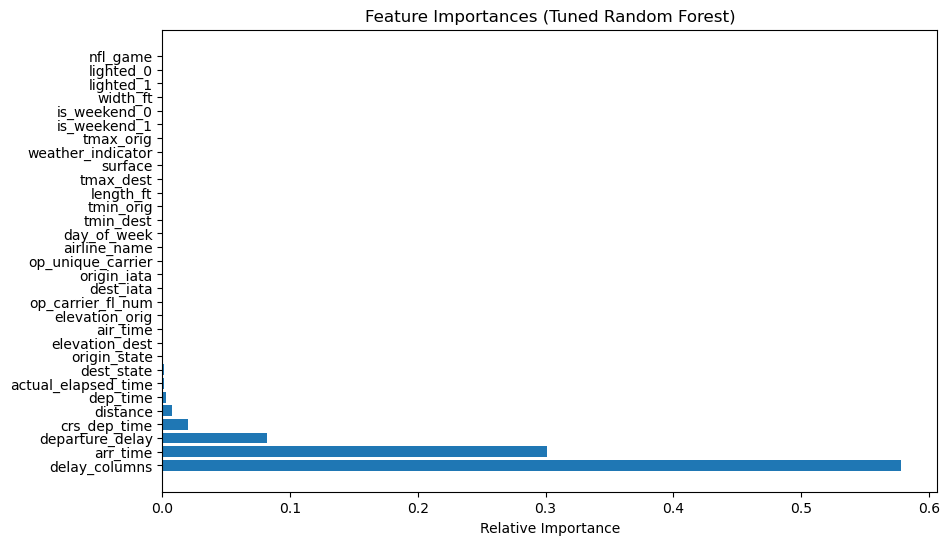

In [58]:
# Feature Importance of Tuned-model

import matplotlib.pyplot as plt

# Get feature importances
importances = best_rfr_model.feature_importances_
# Sort them in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Tuned Random Forest)")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


In [59]:
# Tuned-Model Validation with Cross-Validation

from sklearn.model_selection import cross_val_score

# Evaluate using 5-fold cross-validation
cv_scores = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mae_scores = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"Cross-Validation MSE (5-fold): {-cv_scores.mean()}")
print(f"Cross-Validation MAE (5-fold): {-cv_mae_scores.mean()}")


Cross-Validation MSE (5-fold): 0.10824332818204123
Cross-Validation MAE (5-fold): 0.03323078966826025


## Testing the tuned model

Make Predictions on New Data: Use the trained model (best_rfr_model) to make predictions on new data (test data or future data).

In [61]:
# Group by origin_iata and dest_iata, and calculate the average delay
delay_by_route = df.groupby(['origin_iata', 'dest_iata'])['delay_minutes'].mean().reset_index()

# Sort by delay_minutes to find the routes with the highest average delays
delay_by_route_sorted = delay_by_route.sort_values(by='delay_minutes', ascending=False)

# Show the top routes with the highest average delays
print(delay_by_route_sorted.head())


      origin_iata  dest_iata  delay_minutes
930            67         36      17.051444
2108          173         12      16.970524
1584          128         12      12.734393
929            67         35      12.571398
977            67        112      10.780190


JFK, LAX, ORD are most likely to be late on arrival if you're departing from here. DFW, SFO, and MIA are most likely to be late on arrival if they are your destination airport.

C:\Users\hopeh\AppData\Local\Temp\ipykernel_13212\396641083.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_time_of_day = df.groupby('time_of_day')['delay_minutes'].mean().reset_index()


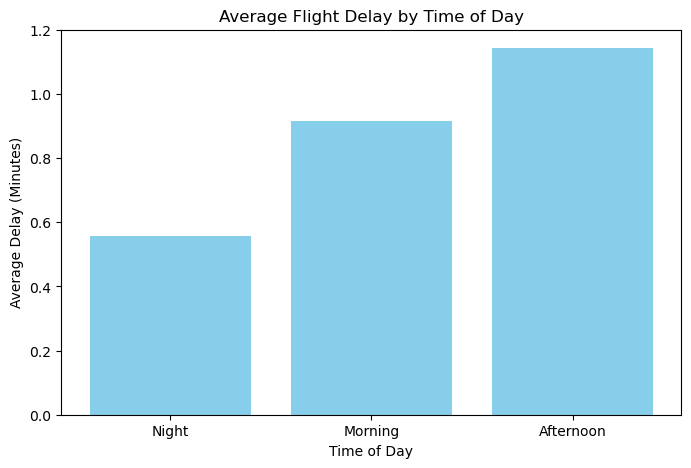

  time_of_day  delay_minutes
0       Night       0.558512
1     Morning       0.916216
2   Afternoon       1.142897
3     Evening            NaN


In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Assuming arr_time is in 'hhmm' format (as an integer or float), let's convert it to hour of day
df['arr_hour'] = df['arr_time'].astype(int) // 100  # Extract the hour (this assumes arr_time is in 'hhmm' format)

# Step 2: Create categories for different times of the day (e.g., Morning, Afternoon, Evening)
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['time_of_day'] = pd.cut(df['arr_hour'], bins=bins, labels=labels, right=False)

# Step 3: Group by 'time_of_day' and calculate the average delay
delay_by_time_of_day = df.groupby('time_of_day')['delay_minutes'].mean().reset_index()

# Step 4: Plot the results
plt.figure(figsize=(8, 5))
plt.bar(delay_by_time_of_day['time_of_day'], delay_by_time_of_day['delay_minutes'], color='skyblue')
plt.xlabel('Time of Day')
plt.ylabel('Average Delay (Minutes)')
plt.title('Average Flight Delay by Time of Day')
plt.show()

# Optional: Show the numeric results as well
print(delay_by_time_of_day)


In [64]:
df.columns

Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'delay_minutes', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1', 'arr_hour', 'time_of_day'], dtype='object')

In [65]:
# day_of_week  op_unique_carrier  op_carrier_fl_num  origin_iata  dest_iata  crs_dep_time  dep_time  arr_time  actual_elapsed_time  air_time  distance  origin_state  dest_state  length_ft  width_ft  surface  elevation_orig  tmax_orig  tmin_orig  weather_indicator  departure_delay  airline_name  nfl_game  delay_columns  elevation_dest  tmax_dest  tmin_dest  delay_minutes  lighted_0  lighted_1  is_weekend_0  is_weekend_1

In [66]:
df.dtypes

day_of_week               int64
op_unique_carrier         int32
op_carrier_fl_num         int64
origin_iata               int32
dest_iata                 int32
crs_dep_time              int64
dep_time                float64
arr_time                float64
actual_elapsed_time     float64
air_time                float64
distance                float64
origin_state              int32
dest_state                int32
length_ft               float64
width_ft                float64
surface                   int32
elevation_orig          float64
tmax_orig               float64
tmin_orig               float64
weather_indicator       float64
departure_delay         float64
airline_name              int32
nfl_game                  int32
delay_columns           float64
elevation_dest          float64
tmax_dest               float64
tmin_dest               float64
delay_minutes           float64
lighted_0                  bool
lighted_1                  bool
is_weekend_0               bool
is_weeke

In [67]:
# Prepare new data

# Load the DataFrame from a CSV file
new_df = pd.read_csv(r'C:\Users\hopeh\Desktop\data_science_bootcamp\flight_times_capstone\preprocessed_data_week.csv', low_memory=False)


# clean new data as df above

In [68]:
# Correct way to access column names
print(new_df.columns)


Index(['day_of_week', 'timestamp', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights', 'distance', 'origin_state', 'dest_state', 'origin_latitude', 'origin_longitude', 'dest_latitude', 'dest_longitude', 'type_of_airport', 'elevation_ft', 'length_ft', 'width_ft', 'surface', 'lighted', 'latitude_orig', 'longitude_orig', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'total_delay_time', 'is_weekend', 'arrival_delay', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'latitude_dest', 'longitude_dest', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'flight_delay_category', 'delay_minutes'], dtype='object')


In [69]:
# Get the list of feature columns from the training data
feature_columns = X_train.columns
print("Feature columns used during training:", feature_columns)


Feature columns used during training: Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1'], dtype='object')


In [70]:
# Correct way to access column names
print(new_df.columns)

Index(['day_of_week', 'timestamp', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights', 'distance', 'origin_state', 'dest_state', 'origin_latitude', 'origin_longitude', 'dest_latitude', 'dest_longitude', 'type_of_airport', 'elevation_ft', 'length_ft', 'width_ft', 'surface', 'lighted', 'latitude_orig', 'longitude_orig', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'total_delay_time', 'is_weekend', 'arrival_delay', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'latitude_dest', 'longitude_dest', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'flight_delay_category', 'delay_minutes'], dtype='object')


In [71]:
new_df = new_df.drop(columns=['taxi_out', 'wheels_off', 'wheels_on', 'taxi_in','crs_elapsed_time', 'origin_latitude', 'origin_longitude', 'dest_latitude', 'dest_longitude', 'type_of_airport', 'latitude_orig', 'longitude_orig', 'elevation_ft', 'latitude_dest', 'longitude_dest', 'total_delay_time', 'flight_delay_category', 'arrival_delay', 'flights', 'crs_arr_time', 'timestamp'], axis=1)

print(new_df.columns)

Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'lighted', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'is_weekend', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'delay_minutes'], dtype='object')


In [72]:
# Select columns of 'object' type and convert them to 'category'
object_columns = new_df.select_dtypes(include='object').columns
new_df[object_columns] = new_df[object_columns].astype('category')

# Verify the changes
print(new_df.dtypes)


day_of_week               int64
op_unique_carrier      category
op_carrier_fl_num         int64
origin_iata            category
dest_iata              category
crs_dep_time              int64
dep_time                float64
arr_time                float64
actual_elapsed_time     float64
air_time                float64
distance                float64
origin_state           category
dest_state             category
length_ft               float64
width_ft                float64
surface                category
lighted                   int64
elevation_orig          float64
tmax_orig               float64
tmin_orig               float64
weather_indicator       float64
is_weekend                int64
departure_delay         float64
airline_name           category
nfl_game               category
delay_columns           float64
elevation_dest          float64
tmax_dest               float64
tmin_dest               float64
delay_minutes           float64
dtype: object


In [73]:
print(new_df.dtypes)


day_of_week               int64
op_unique_carrier      category
op_carrier_fl_num         int64
origin_iata            category
dest_iata              category
crs_dep_time              int64
dep_time                float64
arr_time                float64
actual_elapsed_time     float64
air_time                float64
distance                float64
origin_state           category
dest_state             category
length_ft               float64
width_ft                float64
surface                category
lighted                   int64
elevation_orig          float64
tmax_orig               float64
tmin_orig               float64
weather_indicator       float64
is_weekend                int64
departure_delay         float64
airline_name           category
nfl_game               category
delay_columns           float64
elevation_dest          float64
tmax_dest               float64
tmin_dest               float64
delay_minutes           float64
dtype: object


In [74]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
new_df['day_of_week'] = label_encoder.fit_transform(new_df['day_of_week'])
new_df['op_carrier_fl_num'] = label_encoder.fit_transform(new_df['op_carrier_fl_num'])
new_df['op_unique_carrier'] = label_encoder.fit_transform(new_df['op_unique_carrier'])
new_df['origin_iata'] = label_encoder.fit_transform(new_df['origin_iata'])
new_df['dest_iata'] = label_encoder.fit_transform(new_df['dest_iata'])
new_df['origin_state'] = label_encoder.fit_transform(new_df['origin_state'])
new_df['dest_state'] = label_encoder.fit_transform(new_df['dest_state'])
new_df['airline_name'] = label_encoder.fit_transform(new_df['airline_name'])
new_df['nfl_game'] = label_encoder.fit_transform(new_df['nfl_game'])
new_df['surface'] = label_encoder.fit_transform(new_df['surface'])

In [75]:
# Perform One-Hot Encoding on binary categorical features
new_df = pd.get_dummies(new_df, columns=['lighted', 'is_weekend'])


In [76]:
new_df.columns

Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'delay_minutes', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1'], dtype='object')

In [77]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in new_df.select_dtypes(include=['category']).columns:
    new_df[column] = label_encoder.fit_transform(new_df[column])

# Now calculate the correlation matrix
correlation_matrix = new_df.corr()

# Print the sorted correlation values with respect to 'delay_minutes'
print(correlation_matrix['delay_minutes'].sort_values(ascending=False))

delay_minutes          1.000000
delay_columns          0.324469
arr_time               0.098257
dep_time               0.053221
departure_delay        0.045177
length_ft              0.022759
is_weekend_0           0.019506
crs_dep_time           0.018744
origin_iata            0.017833
distance               0.014690
lighted_1              0.014499
dest_state             0.011264
width_ft               0.010603
op_carrier_fl_num      0.002309
elevation_dest        -0.003640
airline_name          -0.006250
day_of_week           -0.007303
surface               -0.007428
weather_indicator     -0.008232
origin_state          -0.013678
op_unique_carrier     -0.014235
lighted_0             -0.014499
elevation_orig        -0.015865
dest_iata             -0.017985
is_weekend_1          -0.019506
tmin_orig             -0.021999
tmin_dest             -0.021999
air_time              -0.025870
actual_elapsed_time   -0.032596
tmax_orig             -0.032756
tmax_dest             -0.032756
nfl_game

In [78]:
# Predict the target value using the trained model

# 
X_new = new_df.drop(columns=['delay_minutes'])  # Drop the target column

# Make predictions with the trained model
prediction = best_rfr_model.predict(X_new)

print(f"Prediction for new data: {prediction}")


Prediction for new data: [2.61797052 2.61935964 0.86351642 ... 0.22020714 0.22020714 0.22020714]


In [79]:
# visualize the predictions compared to actual values 

In [80]:
print(new_df.columns)


Index(['day_of_week', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_iata', 'dest_iata', 'crs_dep_time', 'dep_time', 'arr_time', 'actual_elapsed_time', 'air_time', 'distance', 'origin_state', 'dest_state', 'length_ft', 'width_ft', 'surface', 'elevation_orig', 'tmax_orig', 'tmin_orig', 'weather_indicator', 'departure_delay', 'airline_name', 'nfl_game', 'delay_columns', 'elevation_dest', 'tmax_dest', 'tmin_dest', 'delay_minutes', 'lighted_0', 'lighted_1', 'is_weekend_0', 'is_weekend_1'], dtype='object')


In [84]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Drop the 'delay_minutes' column from new_df, as it's the target variable
X_new = new_df.drop(columns=['delay_minutes'])  # Drop the target column for prediction

# Assuming 'X_train' is the training data used to fit the model,
# ensure that the features in 'X_new' match the ones in 'X_train'
# If necessary, apply any transformations to 'X_new' (e.g., scaling, encoding) 
# that were applied to the training data before making predictions.

# Make predictions using the model
y_pred = best_rfr_model.predict(X_new)

# If 'delay_minutes' was your target variable, ensure you have it as the true values (y_true)
y_true = new_df['delay_minutes']

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.0333960492427549


In [86]:
# Drop 'delay_minutes' in place
#new_df.drop(['delay_minutes'], axis=1, inplace=True)


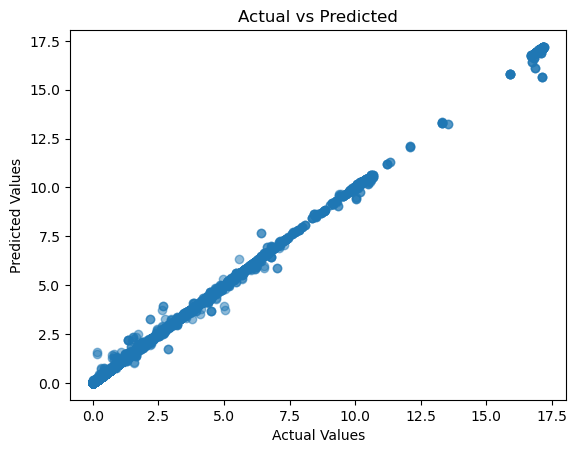

In [88]:
import matplotlib.pyplot as plt

# compare the predicted values with actual values
plt.scatter(y_true, prediction, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()


In [90]:
# Evaluate Prediction Quality:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, prediction)
mse = mean_squared_error(y_true, prediction)
r2 = r2_score(y_true, prediction)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


MAE: 0.0029990546079890273
MSE: 0.00111529610502451
R²: 0.9996975678399977


Mean Absolute Error (MAE):

0.003 (approx)
This means that, on average, the model’s predictions are off by only 0.003 units of the target variable, delay_minutes. This is a very low error, indicating the model is making very precise predictions.


Mean Squared Error (MSE):

0.0011 (approx)
The MSE is a measure of the squared difference between predicted and actual values. Given the very low value, it shows that the model has a very small variance in its predictions, which is a good sign of accurate performance.


R² (Coefficient of Determination):

0.9997
This is extremely high. An R² value close to 1 means that the model is explaining almost all the variability in the target variable. In other words, the model is doing an excellent job of fitting the data, with just 0.03% of the variance unexplained.

In [92]:
# Drop the 'delay_minutes' column from new_df, as it's the target variable
X_new = new_df.drop(columns=['delay_minutes'])  # Drop the target column for prediction

# Assuming 'X_train' is the training data used to fit the model,
# ensure that the features in 'X_new' match the ones in 'X_train'
# If necessary, apply any transformations to 'X_new' (e.g., scaling, encoding) 
# that were applied to the training data before making predictions.

# Make predictions using the model
y_pred = best_rfr_model.predict(X_new)

# If 'delay_minutes' was your target variable, ensure you have it as the true values (y_true)
y_true = new_df['delay_minutes']

Deploy the Model: save the trained model using joblib for later use

In [105]:
import joblib
# Save the model
joblib.dump(best_rfr_model, 'best_random_forest_model.pkl')

# Load the model
loaded_model = joblib.load('best_random_forest_model.pkl')


Monitor Performance

Move forward with deploying the model in a production environment, where it can make real-time predictions on new data.

Monitor Performance:vAfter deployment, make sure to monitor the model's performance over time, as new data could lead to changes in the model’s predictive accuracy.